In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

Describe:
                age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     

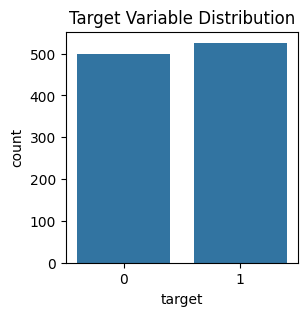

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB

 None


In [51]:
df = pd.read_csv('heart.csv')
print(df.columns)

# eda
print("\nDescribe:\n", df.describe())
print("\nMissing Values:", df.isnull().sum().sum())
print("\nDuplicate Values:", df.duplicated().sum())
print("\nClass Distribution:", df['target'].value_counts()) # yep pretty balanced -> 1 : 526, 0 : 499
plt.figure(figsize=(3,3))
sns.countplot(x='target', data=df)
plt.title('Target Variable Distribution')
plt.show()
print("\n", df.info())

In [52]:
num_cols = df.select_dtypes(exclude=['object', 'string', 'category']).columns
cat_cols = df.select_dtypes(include=['object', 'string', 'category']).columns

print('Categorical Value Columns:', cat_cols)
print('Numerical Value Columns:', num_cols)

Categorical Value Columns: Index([], dtype='object')
Numerical Value Columns: Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [53]:
df.drop_duplicates()

im = SimpleImputer(strategy='median')
df[:] = im.fit_transform(df)

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

Duplicates: Removed because duplicate records can bias the model by repeating the same data points  
Missing Values: None found; but if exist, median imputation would be used to reduce the effect of outliers  
Categorical Data: Dataset has only numeric columns, so no encoding is required  
Imbalanced Data: Already balanced

In [54]:
# features have very different numeric ranges so feauture scaling
print("\nBefore Scaling:\n", df.head())

x = df.drop('target', axis=1)
y = df['target']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns=x.columns)

df_scaled = pd.concat([x_scaled, y.reset_index(drop=True)], axis=1)
print("\nAfter Scaling\n", df_scaled.head())



Before Scaling:
    age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  

After Scaling
         age       sex        cp  trestbps      chol       fbs   restecg  \
0 -0.268437  0.661504 -0.915755 -0.377636 -0.659332 -0.418878  0.891255   
1 -0.158157  0.661504 -0.915755  0.479107 -0.833861  2.387330 -1.004049   
2  1.716595  0.661504 -0.915755  0.764688 -1.396233 -0.418878  0.891255   
3  0.724079  0.661504 -0.915755  0.936037 -0.83

In [55]:
x = df_scaled.drop('target', axis=1)
y = df_scaled['target']

# split into 80-20
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

# split train further into 70-30
xtrain_final, xval, ytrain_final, yval = train_test_split(xtrain, ytrain,  test_size=0.3, random_state=0) 

Validation set is used to tune and evaluate the model during training without touching the test data. It helps check for overfitting and ensures the model generalizes well before final testing.

In [56]:
rf = RandomForestClassifier(random_state=0)
ada = AdaBoostClassifier(random_state=0)
xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

rf.fit(xtrain, ytrain)
rf_train_acc = accuracy_score(ytrain, rf.predict(xtrain))
rf_test_acc = accuracy_score(ytest, rf.predict(xtest))

ada.fit(xtrain, ytrain)
ada_train_acc = accuracy_score(ytrain, ada.predict(xtrain))
ada_test_acc = accuracy_score(ytest, ada.predict(xtest))

xgb.fit(xtrain, ytrain)
xgb_train_acc = accuracy_score(ytrain, xgb.predict(xtrain))
xgb_test_acc= accuracy_score(ytest, xgb.predict(xtest))

# Compare Results
results = pd.DataFrame({
    'Model' : ['RF', 'ADA', 'XGB'],
    'Training Accuracy' : [rf_train_acc, ada_train_acc, xgb_train_acc],
    'Testing Accuracy' : [rf_test_acc, ada_test_acc, xgb_test_acc]
})

print(results)

  Model  Training Accuracy  Testing Accuracy
0    RF           1.000000          1.000000
1   ADA           0.890244          0.882927
2   XGB           1.000000          1.000000


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:12:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
